# Generování Syntetických Dat (Sim2Real Strategy)

Tento notebook slouží k vygenerování trénovací a validační sady pro KalmanNet/KalmanFormer.
Data jsou generována na základě statistiky z reálné trajektorie (`data.mat`), aby se model učil na datech co nejpodobnějších realitě.

**Klíčové vlastnosti:**
- Resampling rychlostí a úhlových rychlostí z reálných dat (zachování korelace).
- Vyhlazování trajektorií (Setrvačnost).
- Validace pomocí UKF (Odfiltrování fyzikálně nesmyslných nebo pro filtr příliš náročných trajektorií).
- Generování dat s biasem a šumem, ale validace na datech bez biasu.

In [1]:
from pathlib import Path
from scipy.io import loadmat
import sys
import os

# Robust path finding for data.mat
current_path = Path.cwd()
possible_data_paths = [
    current_path / 'data' / 'data.mat',
    current_path.parent / 'data' / 'data.mat',
    current_path.parent.parent / 'data' / 'data.mat',
    # Fallback absolute path
    Path('/home/luky/skola/KalmanNet-for-state-estimation/data/data.mat')
]

dataset_path = None
for p in possible_data_paths:
    if p.exists():
        dataset_path = p
        break

if dataset_path is None or not dataset_path.exists():
    print("Warning: data.mat not found automatically.")
    dataset_path = Path('data/data.mat')

print(f"Dataset path: {dataset_path}")

# Add project root to sys.path (2 levels up from debug/test)
notebook_dir = os.getcwd()
project_root = os.path.abspath(os.path.join(notebook_dir, '..', '..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)
print(f"Project root added: {project_root}")
import numpy as np
import torch
import matplotlib.pyplot as plt
from scipy.interpolate import RegularGridInterpolator
import random
from tqdm import tqdm
import shutil
import Filters
from Systems import DynamicSystemTAN
import torch.nn.functional as func


Dataset path: /home/luky/skola/KalmanNet-for-state-estimation/data/data.mat
Project root added: /home/luky/skola/KalmanNet-for-state-estimation


In [2]:
# Nastavení seedů pro reprodukovatelnost
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

Device: cuda


In [3]:
# Načtení dat a mapy
mat_data = loadmat(dataset_path)

souradniceX_mapa = mat_data['souradniceX']
souradniceY_mapa = mat_data['souradniceY']
souradniceZ_mapa = mat_data['souradniceZ']
souradniceGNSS = mat_data['souradniceGNSS'] 
x_axis_unique = souradniceX_mapa[0, :]
y_axis_unique = souradniceY_mapa[:, 0]

print(f"Map X: {x_axis_unique.shape}, Y: {y_axis_unique.shape}, Z: {souradniceZ_mapa.shape}")

# Interpolátor (pro použití mimo torch, pokud potřeba)
terMap_interpolator = RegularGridInterpolator(
    (y_axis_unique, x_axis_unique),
    souradniceZ_mapa,
    bounds_error=False, 
    fill_value=np.nan
)

Map X: (2500,), Y: (2500,), Z: (2500, 2500)


In [4]:
# Definice System Modelu
state_dim = 4
obs_dim = 3
dT = 1
q = 1

F = torch.tensor([[1.0, 0.0, dT, 0.0],
                   [0.0, 1.0, 0.0, dT],
                   [0.0, 0.0, 1.0, 0.0],
                   [0.0, 0.0, 0.0, 1.0]])

Q = q* torch.tensor([[dT**3/3, 0.0, dT**2/2, 0.0],
                   [0.0, dT**3/3, 0.0, dT**2/2],
                   [dT**2/2, 0.0, dT, 0.0],
                   [0.0, dT**2/2, 0.0, dT]])
R = torch.tensor([[3.0**2, 0.0, 0.0],
                   [0.0, 1.0**2, 0.0],
                   [0.0, 0.0, 1.0**2]])

initial_velocity = torch.from_numpy(np.array([0,0]))
initial_position = torch.from_numpy(souradniceGNSS[:2, 0])
x_0 = torch.cat([
    initial_position,
    initial_velocity
]).float()

P_0 = torch.tensor([[25.0, 0.0, 0.0, 0.0],
                    [0.0, 25.0, 0.0, 0.0],
                    [0.0, 0.0, 0.5, 0.0],
                    [0.0, 0.0, 0.0, 0.5]])

# Diferencovatelná funkce h(x) pro terén
def h_nl_differentiable(x: torch.Tensor, map_tensor, x_min, x_max, y_min, y_max) -> torch.Tensor:
    batch_size = x.shape[0]

    px = x[:, 0]
    py = x[:, 1]

    px_norm = 2.0 * (px - x_min) / (x_max - x_min) - 1.0
    py_norm = 2.0 * (py - y_min) / (y_max - y_min) - 1.0

    sampling_grid = torch.stack((px_norm, py_norm), dim=1).view(batch_size, 1, 1, 2)

    vyska_terenu_batch = func.grid_sample(
        map_tensor.expand(batch_size, -1, -1, -1),
        sampling_grid, 
        mode='bilinear', 
        padding_mode='border',
        align_corners=True
    )

    vyska_terenu = vyska_terenu_batch.view(batch_size)

    eps = 1e-12
    vx_w, vy_w = x[:, 2], x[:, 3]
    norm_v_w = torch.sqrt(vx_w**2 + vy_w**2).clamp(min=eps)
    cos_psi = vx_w / norm_v_w
    sin_psi = vy_w / norm_v_w

    vx_b = cos_psi * vx_w - sin_psi * vy_w 
    vy_b = sin_psi * vx_w + cos_psi * vy_w

    result = torch.stack([vyska_terenu, vx_b, vy_b], dim=1)
    return result

terMap_tensor = torch.from_numpy(souradniceZ_mapa).float().unsqueeze(0).unsqueeze(0).to(device)
x_min, x_max = x_axis_unique.min(), x_axis_unique.max()
y_min, y_max = y_axis_unique.min(), y_axis_unique.max()

h_wrapper = lambda x: h_nl_differentiable(
    x, 
    map_tensor=terMap_tensor, 
    x_min=x_min, 
    x_max=x_max, 
    y_min=y_min, 
    y_max=y_max
)

system_model = DynamicSystemTAN(
    state_dim=state_dim,
    obs_dim=obs_dim,
    Q=Q.float(),
    R=R.float(),
    Ex0=x_0.float(),
    P0=P_0.float(),
    F=F.float(),
    h=h_wrapper,
    x_axis_unique=x_axis_unique, 
    y_axis_unique=y_axis_unique,
    device=device
)

print("System Model Initialized")

INFO: DynamicSystemTAN inicializován s hranicemi mapy:
  X: [1476611.42, 1489541.47]
  Y: [6384032.63, 6400441.34]
System Model Initialized


In [5]:
# === 1. EXTRAKCE STATISTIKY Z REÁLNÉ TRAJEKTORIE ===
def extract_driving_stats(real_traj_tensor):
    positions = real_traj_tensor[:, :2]
    deltas = positions[1:] - positions[:-1]
    speeds = torch.norm(deltas, dim=1)
    headings = torch.atan2(deltas[:, 1], deltas[:, 0])
    yaw_rates = headings[1:] - headings[:-1]
    # Ošetření přechodu -pi/pi
    yaw_rates = (yaw_rates + np.pi) % (2 * np.pi) - np.pi
    speeds = speeds[:-1]
    
    # Filtrujeme jen rozumné rychlosti (např. když auto stojí, yaw_rate je šum)
    valid_mask = (torch.isfinite(speeds) & torch.isfinite(yaw_rates) & (speeds > 0.5))
    clean_speeds = speeds[valid_mask]
    clean_yaw_rates = yaw_rates[valid_mask]
    
    print(f"✅ Statistika: {len(clean_speeds)} vzorků. AvgSpeed: {clean_speeds.mean():.2f} m/s")
    return clean_speeds, clean_yaw_rates

# Příprava reálných dat
real_traj_np = souradniceGNSS[:2, :].T 
real_traj_tensor = torch.from_numpy(real_traj_np).float().to(device)
real_speeds, real_yaws = extract_driving_stats(real_traj_tensor)

✅ Statistika: 1263 vzorků. AvgSpeed: 26.76 m/s


In [6]:
def simulate_batch_ackermann(system, batch_size, seq_len, stats_speeds, stats_yaws, speed_scale=0.99):
    device = system.Ex0.device
    dt = 1.0
    
    margin = 150.0
    x_min, x_max = system.min_x + margin, system.max_x - margin
    y_min, y_max = system.min_y + margin, system.max_y - margin
    
    start_x = (torch.rand(batch_size, 1, device=device) * (x_max - x_min)) + x_min
    start_y = (torch.rand(batch_size, 1, device=device) * (y_max - y_min)) + y_min
    start_psi = (torch.rand(batch_size, 1, device=device) * 2 * np.pi) - np.pi
    
    # Resampling statistik
    rand_idx = torch.randint(0, len(stats_speeds), (batch_size, seq_len), device=device)
    chosen_v = stats_speeds[rand_idx] * speed_scale
    chosen_omega = stats_yaws[rand_idx]
    
    # Vyhlazování (Simulace záměru řidiče)
    alpha_v = 0.3      
    alpha_omega = 0.4  
    
    smooth_v = torch.zeros_like(chosen_v)
    smooth_omega = torch.zeros_like(chosen_omega)
    
    curr_v = chosen_v[:, 0]
    curr_omega = chosen_omega[:, 0]
    
    for t in range(seq_len):
        curr_v = (1 - alpha_v) * curr_v + alpha_v * chosen_v[:, t]
        curr_omega = (1 - alpha_omega) * curr_omega + alpha_omega * chosen_omega[:, t]
        smooth_v[:, t] = curr_v
        smooth_omega[:, t] = curr_omega
        
    traj_x = []
    traj_y = []
    traj_vx = []
    traj_vy = []
    
    curr_x, curr_y, curr_psi = start_x.squeeze(), start_y.squeeze(), start_psi.squeeze()
    
    # === NASTAVENÍ PROCESNÍHO ŠUMU (Q) ===
    # Toto určuje, jak moc je pohyb "nepředvídatelný" pro Constant Velocity model
    # std_v = 0.2 m/s (chyba v rychlosti / prokluz / nerovnost)
    # std_omega = 0.1 rad/s (chyba v řízení)
    q_std_v = 0.2
    q_std_omega = 0.1
    
    for t in range(seq_len):
        # 1. Čistý příkaz (co řidič chce)
        v_cmd = smooth_v[:, t]
        omega_cmd = smooth_omega[:, t]
        
        # 2. PŘIDÁNÍ ŠUMU DO DYNAMIKY (Process Noise)
        # Tady se děje ta magie. Auto neudělá přesně to, co se po něm chce.
        noise_v = torch.randn_like(v_cmd) * q_std_v
        noise_omega = torch.randn_like(omega_cmd) * q_std_omega
        
        v_real = v_cmd + noise_v
        omega_real = omega_cmd + noise_omega
        
        # 3. Fyzika s reálnými (zašuměnými) hodnotami
        vx = v_real * torch.cos(curr_psi)
        vy = v_real * torch.sin(curr_psi)
        
        # Ukládáme Ground Truth (to, co se skutečně stalo)
        traj_x.append(curr_x)
        traj_y.append(curr_y)
        traj_vx.append(vx)
        traj_vy.append(vy)
        
        # 4. Integrace (Euler)
        # Chyba v rychlosti se zde "zapeče" do chyby v pozici pro příští krok
        curr_x = curr_x + vx * dt
        curr_y = curr_y + vy * dt
        curr_psi = curr_psi + omega_real * dt
        
    X = torch.stack(traj_x, dim=1)
    Y = torch.stack(traj_y, dim=1)
    VX = torch.stack(traj_vx, dim=1)
    VY = torch.stack(traj_vy, dim=1)
    
    return torch.stack([X, Y, VX, VY], dim=2)

In [7]:
# === 3. HLAVNÍ LOOP GENEROVÁNÍ (KONTROLOVANÉ PROSTŘEDÍ) ===

DATA_DIR = './generated_data_synthetic_controlled' # Nový název složky
if os.path.exists(DATA_DIR): shutil.rmtree(DATA_DIR)
os.makedirs(DATA_DIR)

BATCH_SIZE_GEN = 256  
filter_model = Filters.UnscentedKalmanFilter(system_model)
filter_name = "UKF"

# Konfigurace datasetů
# ZVÝŠIL JSEM LIMITY (Max RMSE), abychom nevyhazovali "těžká" data, ale jen "rozbitá" data.
CONFIGS = [
    # (Délka, Cíl Train, Cíl Val, Max RMSE [m] pro detekci divergence)
    (10,  2000, 500, 10.0),   # Bylo 10.0 -> Teď 50.0 (zachytí jen totální úlety)
    (100, 2000, 500, 50.0),  # Bylo 30.0 -> Teď 100.0
    (200, 2000, 500, 60.0),  # Bylo 30.0 -> Teď 100.0
    (300, 2000, 500, 70.0)   # Bylo 70.0 -> Teď 200.0
]

for seq_len, n_train, n_val, filter_thresh in CONFIGS:
    subset_dir = os.path.join(DATA_DIR, f'len_{seq_len}')
    os.makedirs(subset_dir, exist_ok=True)
    
    print(f"\n🚀 Generuji sadu (Synthetic Controlled): Délka={seq_len} | Cíl={n_train}/{n_val} | Filter Divergence > {filter_thresh}m")
    
    for split, target_count in [('train', n_train), ('val', n_val)]:
        valid_x_list = []
        valid_y_list = []
        
        stats = {
            'generated': 0, 'dropped_bounds': 0, 'dropped_flat': 0,
            'dropped_filter_crash': 0, 'dropped_divergence': 0, # Přejmenováno z rmse_high
            'accepted': 0, 'avg_rmse_rejected': 0.0
        }
        
        pbar = tqdm(total=target_count, desc=f"  -> {split.upper()}")
        batch_counter = 0
        
        while len(valid_x_list) < target_count:
            batch_counter += 1
            x_batch = simulate_batch_ackermann(system_model, BATCH_SIZE_GEN, seq_len, real_speeds, real_yaws)
            stats['generated'] += BATCH_SIZE_GEN
            
            # Pre-filter (Hranice mapy)
            in_bounds = (
                (x_batch[:, :, 0].min(dim=1).values > system_model.min_x) &
                (x_batch[:, :, 0].max(dim=1).values < system_model.max_x) &
                (x_batch[:, :, 1].min(dim=1).values > system_model.min_y) &
                (x_batch[:, :, 1].max(dim=1).values < system_model.max_y)
            )
            x_cands = x_batch[in_bounds]
            stats['dropped_bounds'] += (BATCH_SIZE_GEN - len(x_cands))
            if len(x_cands) == 0: continue
            
            try:
                batch_size_real = x_cands.shape[0]
                flat_x = x_cands.reshape(-1, 4)
                flat_y = system_model.measure(flat_x) 
                y_ideal = flat_y.reshape(batch_size_real, seq_len, 3)
                
                noise_std = torch.tensor([5.0, 1.0, 1.0], device=system_model.Ex0.device)
                white_noise = torch.randn_like(y_ideal) * noise_std
                
                # APLIKACE ŠUMU
                y_with_noise = y_ideal + white_noise

                # 2. ŽÁDNÝ BIAS (Podle požadavku)
                # Data pro validaci i trénink jsou identická (čistý model + šum)
                y_for_dataset = y_with_noise
                
            except Exception as e:
                print(f"Chyba měření: {e}")
                continue

            # Filter Validace (Detekce divergence/outlierů)
            rmse_sum_rejected = 0
            rmse_count_rejected = 0
            
            for i in range(len(x_cands)):
                if len(valid_x_list) >= target_count: break
                

                if torch.std(y_for_dataset[i, :, 0]) < 1.0: 
                    stats['dropped_flat'] += 1
                    continue
                
                try:
                    x_gt = x_cands[i]
                    

                    res = filter_model.process_sequence(y_for_dataset[i], Ex0=x_gt[0], P0=system_model.P0)
                    x_est = res['x_filtered']
                    
                    len_est = x_est.shape[0]
                    len_gt = x_gt.shape[0]
                    min_len = min(len_est, len_gt)
                    
                    diff = x_est[:min_len, :2] - x_gt[:min_len, :2]
                    rmse = torch.sqrt(torch.mean(torch.sum(diff**2, dim=1))).item()

                    if rmse < filter_thresh:
                        valid_x_list.append(x_gt.cpu())
                        valid_y_list.append(y_for_dataset[i].cpu())
                        stats['accepted'] += 1
                        pbar.update(1)
                    else:
                        stats['dropped_divergence'] += 1
                        rmse_sum_rejected += rmse
                        rmse_count_rejected += 1
                        
                except Exception:
                    stats['dropped_filter_crash'] += 1
                    continue
            
            if rmse_count_rejected > 0:
                current_avg = rmse_sum_rejected / rmse_count_rejected
                if stats['avg_rmse_rejected'] == 0: stats['avg_rmse_rejected'] = current_avg
                else: stats['avg_rmse_rejected'] = 0.9 * stats['avg_rmse_rejected'] + 0.1 * current_avg

            if batch_counter % 10 == 0:
                acc_rate = (stats['accepted'] / (stats['generated'] + 1e-6)) * 100
                tqdm.write(f"\n--- DEBUG (Batch {batch_counter}) ---")
                tqdm.write(f"   Gen: {stats['generated']} | Acc: {stats['accepted']} ({acc_rate:.2f}%)")
                tqdm.write(f"   Drop: Divergence>{filter_thresh}m={stats['dropped_divergence']} (Avg rej RMSE: {stats['avg_rmse_rejected']:.1f}m)")
                    
        pbar.close()
        torch.save({'x': torch.stack(valid_x_list), 'y': torch.stack(valid_y_list)}, os.path.join(subset_dir, f'{split}.pt'))

print("\n✨ Hotovo. Dataset (Synthetic Controlled / No Bias) vygenerován.")


🚀 Generuji sadu (Synthetic Controlled): Délka=10 | Cíl=2000/500 | Filter Divergence > 10.0m


  -> VAL: 100%|██████████| 500/500 [00:06<00:00, 77.80it/s]



🚀 Generuji sadu (Synthetic Controlled): Délka=100 | Cíl=2000/500 | Filter Divergence > 50.0m


  -> TRAIN: 100%|██████████| 2000/2000 [03:49<00:00,  8.71it/s]



--- DEBUG (Batch 10) ---
   Gen: 2560 | Acc: 2000 (78.12%)
   Drop: Divergence>50.0m=19 (Avg rej RMSE: 54.7m)


  -> VAL: 100%|██████████| 500/500 [00:56<00:00,  8.78it/s]



🚀 Generuji sadu (Synthetic Controlled): Délka=200 | Cíl=2000/500 | Filter Divergence > 60.0m


  -> TRAIN:  79%|███████▉  | 1582/2000 [06:08<01:34,  4.42it/s]


--- DEBUG (Batch 10) ---
   Gen: 2560 | Acc: 1582 (61.80%)
   Drop: Divergence>60.0m=63 (Avg rej RMSE: 68.9m)


  -> VAL: 100%|██████████| 500/500 [01:56<00:00,  4.30it/s]



🚀 Generuji sadu (Synthetic Controlled): Délka=300 | Cíl=2000/500 | Filter Divergence > 70.0m


  -> TRAIN:  65%|██████▍   | 1292/2000 [07:32<03:58,  2.96it/s]


--- DEBUG (Batch 10) ---
   Gen: 2560 | Acc: 1292 (50.47%)
   Drop: Divergence>70.0m=74 (Avg rej RMSE: 129.5m)


  -> VAL: 100%|██████████| 500/500 [02:53<00:00,  2.88it/s]


✨ Hotovo. Dataset (Synthetic Controlled / No Bias) vygenerován.



🚀 Generuji TEST sadu: Délka=1000 | Cíl=20 | Max UKF RMSE < 100.0m


  -> TEST: 100%|██████████| 20/20 [00:22<00:00,  1.13s/it]


✅ Testovací sada vygenerována: 20 trajektorií o délce 1000.
   Uloženo v: ./generated_data_synthetic_controlled/test_set/test.pt


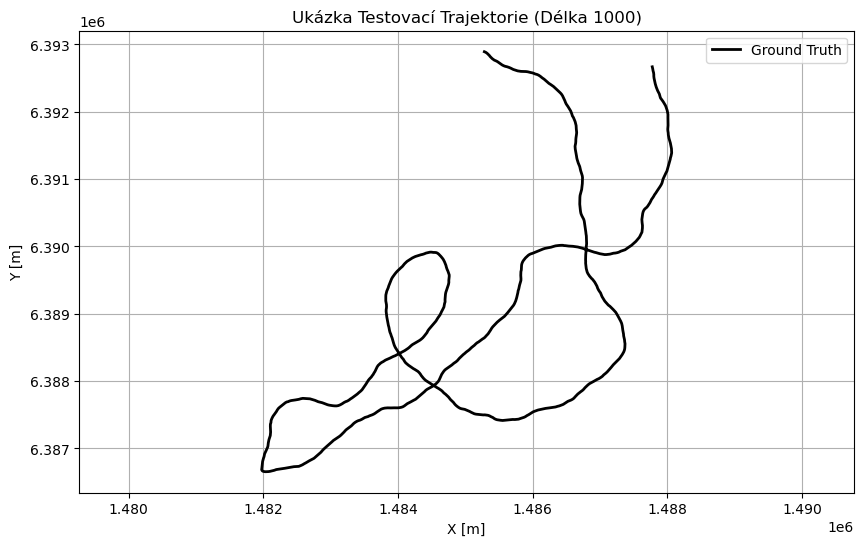

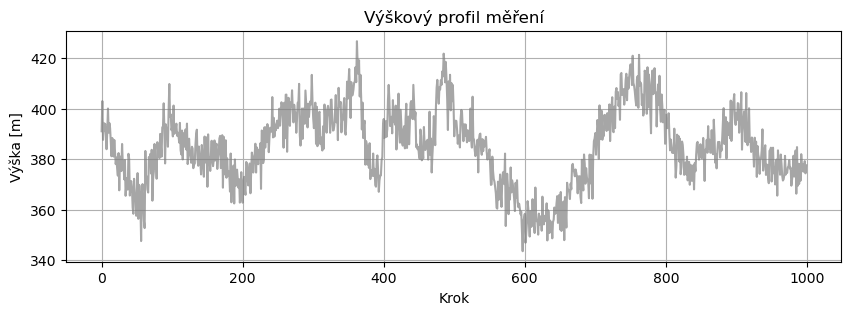

In [8]:
# === 4. GENERATING TEST SET (Length 1000) ===

TEST_SEQ_LEN = 1000
TEST_COUNT = 20
TEST_THRESH = 100.0  # Benevolentní práh pro dlouhé sekvence (filtruje jen divergence)
TEST_BATCH_SIZE = 64 # Menší batch, protože sekvence je dlouhá (šetříme paměť)

test_dir = os.path.join(DATA_DIR, 'test_set')
os.makedirs(test_dir, exist_ok=True)

print(f"\n🚀 Generuji TEST sadu: Délka={TEST_SEQ_LEN} | Cíl={TEST_COUNT} | Max UKF RMSE < {TEST_THRESH}m")

valid_x_list = []
valid_y_list = []

stats = {
    'generated': 0, 'dropped_bounds': 0, 'dropped_flat': 0,
    'dropped_filter_crash': 0, 'dropped_divergence': 0,
    'accepted': 0, 'avg_rmse_rejected': 0.0
}

pbar = tqdm(total=TEST_COUNT, desc="  -> TEST")
batch_counter = 0

while len(valid_x_list) < TEST_COUNT:
    batch_counter += 1
    # Generování
    x_batch = simulate_batch_ackermann(system_model, TEST_BATCH_SIZE, TEST_SEQ_LEN, real_speeds, real_yaws)
    stats['generated'] += TEST_BATCH_SIZE
    
    # Pre-filter (Hranice mapy)
    in_bounds = (
        (x_batch[:, :, 0].min(dim=1).values > system_model.min_x) &
        (x_batch[:, :, 0].max(dim=1).values < system_model.max_x) &
        (x_batch[:, :, 1].min(dim=1).values > system_model.min_y) &
        (x_batch[:, :, 1].max(dim=1).values < system_model.max_y)
    )
    x_cands = x_batch[in_bounds]
    if len(x_cands) == 0: 
        stats['dropped_bounds'] += TEST_BATCH_SIZE
        continue
    stats['dropped_bounds'] += (TEST_BATCH_SIZE - len(x_cands))
    
    try:
        batch_size_real = x_cands.shape[0]
        flat_x = x_cands.reshape(-1, 4)
        flat_y = system_model.measure(flat_x) 
        y_ideal = flat_y.reshape(batch_size_real, TEST_SEQ_LEN, 3)
        
        # 1. Bílý šum (Konzistentní s tréninkem: [5.0, 1.0, 1.0])
        noise_std = torch.tensor([5.0, 1.0, 1.0], device=system_model.Ex0.device)
        white_noise = torch.randn_like(y_ideal) * noise_std
        
        y_with_noise = y_ideal + white_noise
        
        # Žádný bias pro testování (aby to odpovídalo "Synthetic Controlled")
        y_for_dataset = y_with_noise
        
    except Exception as e:
        print(f"Chyba měření: {e}")
        continue

    # Filter Validace
    rmse_sum_rejected = 0
    rmse_count_rejected = 0
    
    for i in range(len(x_cands)):
        if len(valid_x_list) >= TEST_COUNT: break
        
        # Kontrola "plochosti"
        if torch.std(y_for_dataset[i, :, 0]) < 1.0: 
            stats['dropped_flat'] += 1
            continue
        
        try:
            x_gt = x_cands[i]
            
            # Validace pomocí UKF
            res = filter_model.process_sequence(y_for_dataset[i], Ex0=x_gt[0], P0=system_model.P0)
            x_est = res['x_filtered']
            
            # RMSE výpočet
            diff = x_est[:, :2] - x_gt[:, :2]
            rmse = torch.sqrt(torch.mean(torch.sum(diff**2, dim=1))).item()
            
            # FILTRACE DIVERGENCÍ
            if rmse < TEST_THRESH:
                valid_x_list.append(x_gt.cpu())
                valid_y_list.append(y_for_dataset[i].cpu())
                stats['accepted'] += 1
                pbar.update(1)
            else:
                stats['dropped_divergence'] += 1
                rmse_sum_rejected += rmse
                rmse_count_rejected += 1
                
        except Exception:
            stats['dropped_filter_crash'] += 1
            continue

pbar.close()

# Uložení
test_data = {'x': torch.stack(valid_x_list), 'y': torch.stack(valid_y_list)}
torch.save(test_data, os.path.join(test_dir, 'test.pt'))

print(f"\n✅ Testovací sada vygenerována: {len(valid_x_list)} trajektorií o délce {TEST_SEQ_LEN}.")
print(f"   Uloženo v: {os.path.join(test_dir, 'test.pt')}")

# --- Rychlá vizualizace jedné trajektorie pro kontrolu ---
import matplotlib.pyplot as plt

x_vis = valid_x_list[0].numpy()
y_vis = valid_y_list[0].numpy()

plt.figure(figsize=(10, 6))
plt.plot(x_vis[:, 0], x_vis[:, 1], label='Ground Truth', color='black', linewidth=2)
plt.title(f"Ukázka Testovací Trajektorie (Délka {TEST_SEQ_LEN})")
plt.xlabel("X [m]")
plt.ylabel("Y [m]")
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.show()

# Zobrazení výškového profilu
plt.figure(figsize=(10, 3))
plt.plot(y_vis[:, 0], label='Měření Barometru (s šumem)', color='gray', alpha=0.7)
plt.title("Výškový profil měření")
plt.xlabel("Krok")
plt.ylabel("Výška [m]")
plt.grid(True)
plt.show()